# importation

In [9]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, UnidentifiedImageError
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

# preparer donner tabulaires et images

In [15]:
import pandas as pd 
df=pd.read_csv('D:\ECG_data\classification.csv')

<>:2: SyntaxWarning: invalid escape sequence '\E'
<>:2: SyntaxWarning: invalid escape sequence '\E'
C:\Users\pc\AppData\Local\Temp\ipykernel_24276\3111199477.py:2: SyntaxWarning: invalid escape sequence '\E'
  df=pd.read_csv('D:\ECG_data\classification.csv')


In [16]:
import pandas as pd
import os

# Chemin du dossier des images
image_dir = 'records100'

# Fonction pour corriger le chemin des images
def correct_image_path(path):
    parts = path.split("/")  # Séparer les parties du chemin
    new_path = os.path.join(image_dir, parts[-1] + ".png")  # Utiliser le répertoire d'images et ajouter ".png"
    return new_path

# Appliquer la correction des chemins
df["filename_lr"] = df["filename_lr"].apply(correct_image_path)

# Fonction pour vérifier si le fichier image existe
def check_image_existence(row):
    # Vérifier si l'image existe
    if os.path.exists(row['filename_lr']):
        return row['filename_lr']
    else:
        return None  # Si l'image n'existe pas, retourner None

# Appliquer la vérification des chemins d'image
df['filename_lr'] = df.apply(check_image_existence, axis=1)

# Supprimer les lignes où les images n'existent pas
df_valid = df.dropna(subset=['filename_lr'])




In [ ]:

# Configuration du device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

df = df_valid

# Définition des colonnes
tabular_features = ["age", "sex", "height", "weight", "infarction_stadium1", "infarction_stadium2", "pacemaker"]
image_column = "filename_lr"
target_columns = ["Myocardial Infarction (MI)", "ST/T Change (STTC)", "Conduction Disturbance (CD)", "Hypertrophy (HYP)", "Normal (NORM)"]

# Préparation des données
X_tabular = StandardScaler().fit_transform(df[tabular_features].values)
X_images = df[image_column].values
y = df[target_columns].values

X_train_tab, X_test_tab, X_train_img, X_test_img, y_train, y_test = train_test_split(
    X_tabular, X_images, y, test_size=0.2, random_state=42
)

In [ ]:

# Dataset class
class ECGDataset(Dataset):
    def __init__(self, image_folder, image_paths, tabular_data, labels, transform=None):
        self.image_folder = image_folder
        self.image_paths = image_paths
        self.tabular_data = torch.tensor(tabular_data, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.float32)
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = f"{self.image_paths[idx]}"
        
        try:
            image = Image.open(img_path).convert("L")
        except (UnidentifiedImageError, OSError):
            print(f"⚠️ Image ignorée : {img_path}")
            return None  # Ignore cette image corrompue

        if self.transform:
            image = self.transform(image)

        return image, self.tabular_data[idx], self.labels[idx]

In [ ]:

# Transformations des images
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])



# 📌 Datasets et Dataloaders avec filtrage des images corrompues
train_dataset = ECGDataset( X_train_img, X_train_tab, y_train, transform)
test_dataset = ECGDataset( X_test_img, X_test_tab, y_test, transform)

def collate_fn(batch):
    """ Filtrer les valeurs None pour éviter les erreurs """
    batch = [b for b in batch if b is not None]
    if len(batch) == 0:
        return None
    return torch.utils.data.default_collate(batch)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)


# definition du modéle

In [ ]:
# Définition du modèle
class ECGClassifier(nn.Module):
    def __init__(self):
        super(ECGClassifier, self).__init__()
        
        # CNN EfficientNet-B0
        self.cnn = models.efficientnet_b0(pretrained=True)
        self.cnn.features[0][0] = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        num_features = self.cnn.classifier[1].in_features
        self.cnn.classifier = nn.Identity()
        
        # MLP pour données tabulaires
        self.mlp = nn.Sequential(
            nn.Linear(len(tabular_features), 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(32, 64),
            nn.ReLU()
        )
        
        # Fusion
        self.fc = nn.Sequential(
            nn.Linear(num_features + 64, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, len(target_columns)),
        )

    def forward(self, image, tabular):
        x1 = self.cnn(image)
        x2 = self.mlp(tabular)
        x = torch.cat((x1, x2), dim=1)
        x = self.fc(x)
        return x

# entrainement du modele 

In [ ]:

# Initialisation du modèle, perte et optimiseur
model = ECGClassifier().to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)

# Early Stopping
best_loss = float("inf")
patience = 7
wait = 0

# Entraînement
num_epochs = 50
train_losses, val_losses = [], []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, tabular_data, labels in train_loader:
        images, tabular_data, labels = images.to(device), tabular_data.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images, tabular_data)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    val_loss = 0.0
    model.eval()
    with torch.no_grad():
        for images, tabular_data, labels in test_loader:
            images, tabular_data, labels = images.to(device), tabular_data.to(device), labels.to(device)
            outputs = model(images, tabular_data)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    # Normalisation de la loss
    val_loss /= len(test_loader)
    
    scheduler.step(val_loss)
    train_losses.append(running_loss / len(train_loader))
    val_losses.append(val_loss)
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")

    # Early stopping
    if val_loss < best_loss:
        best_loss = val_loss
        torch.save(model.state_dict(), "best_model.pth")  # Sauvegarde du meilleur modèle
        wait = 0
    else:
        wait += 1
        if wait >= patience:
            print("⏹ Early stopping déclenché")
            break

# Charger le meilleur modèle
model.load_state_dict(torch.load("best_model.pth"))




/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/50], Train Loss: 0.3631, Val Loss: 0.2566
Epoch [2/50], Train Loss: 0.2868, Val Loss: 0.2511
Epoch [3/50], Train Loss: 0.2681, Val Loss: 0.2365
Epoch [4/50], Train Loss: 0.2566, Val Loss: 0.2482
Epoch [5/50], Train Loss: 0.2414, Val Loss: 0.2352
Epoch [6/50], Train Loss: 0.2388, Val Loss: 0.2360
Epoch [7/50], Train Loss: 0.2305, Val Loss: 0.2282
Epoch [8/50], Train Loss: 0.2277, Val Loss: 0.2189
Epoch [9/50], Train Loss: 0.2231, Val Loss: 0.2237
Epoch [10/50], Train Loss: 0.2131, Val Loss: 0.2098
Epoch [11/50], Train Loss: 0.2119, Val Loss: 0.2148
Epoch [12/50], Train Loss: 0.2067, Val Loss: 0.2223
Epoch [13/50], Train Loss: 0.2022, Val Loss: 0.2264
Epoch [14/50], Train Loss: 0.2033, Val Loss: 0.2391
Epoch [15/50], Train Loss: 0.1992, Val Loss: 0.2297
Epoch [16/50], Train Loss: 0.1933, Val Loss: 0.2257
Epoch [17/50], Train Loss: 0.1655, Val Loss: 0.2158
⏹ Early stopping déclenché


<ipython-input-10-f64f334fd32d>:179: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pth"))


<All keys matched successfully>

# evaluation du modele

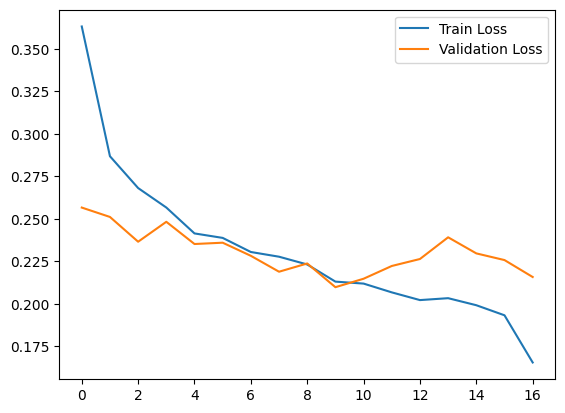

Accuracy: 0.6979
Precision: 0.7527
Recall: 0.6865
F1 Score: 0.7122


In [11]:
# Tracer les courbes de loss
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.legend()
plt.show()

# Évaluation
def evaluate_model(model, test_loader):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, tabular_data, labels in test_loader:
            images, tabular_data, labels = images.to(device), tabular_data.to(device), labels.to(device)
            outputs = model(images, tabular_data)
            preds = (torch.sigmoid(outputs) > 0.5).float()
            all_preds.append(preds.cpu().numpy())
            all_labels.append(labels.cpu().numpy())
    all_preds = np.vstack(all_preds)
    all_labels = np.vstack(all_labels)
    print(f"Accuracy: {accuracy_score(all_labels, all_preds):.4f}")
    print(f"Precision: {precision_score(all_labels, all_preds, average='macro'):.4f}")
    print(f"Recall: {recall_score(all_labels, all_preds, average='macro'):.4f}")
    print(f"F1 Score: {f1_score(all_labels, all_preds, average='macro'):.4f}")

evaluate_model(model, test_loader)

# affichage 5 exemples de predictions 

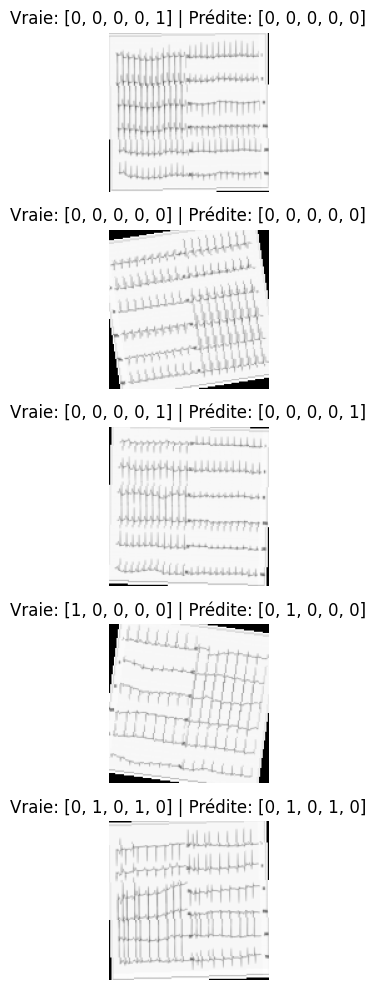

In [13]:
import torch.nn.functional as F

# Charger le modèle en mode évaluation
model.eval()

# Sélectionner quelques exemples du test set
num_samples = 5
samples = []

with torch.no_grad():
    for images, tabular_data, labels in test_loader:
        images, tabular_data, labels = images.to(device), tabular_data.to(device), labels.to(device)
        outputs = model(images, tabular_data)
        probs = torch.sigmoid(outputs)  # Convertir en probabilités (puisque BCEWithLogitsLoss est utilisé)
        samples.append((images.cpu(), probs.cpu(), labels.cpu()))
        
        if len(samples) >= num_samples:
            break

# Afficher les prédictions avec les vraies valeurs
fig, axes = plt.subplots(num_samples, 1, figsize=(8, 10))

for i, (images, preds, labels) in enumerate(samples[:num_samples]):
    img = images[0].squeeze().numpy()  # Convertir en image
    pred_labels = (preds[0] > 0.5).int().tolist()  # Seuil à 0.5 pour classer
    true_labels = labels[0].int().tolist()

    axes[i].imshow(img, cmap="gray")
    axes[i].axis("off")
    axes[i].set_title(f"Vraie: {true_labels} | Prédite: {pred_labels}")

plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import classification_report

# Générer le rapport de classification
print("📊 Classification Report :")
print(classification_report(all_labels, all_preds, target_names=target_columns))


📊 Classification Report :
                             precision    recall  f1-score   support

 Myocardial Infarction (MI)       0.84      0.64      0.72       151
         ST/T Change (STTC)       0.63      0.63      0.63       155
Conduction Disturbance (CD)       0.76      0.76      0.76        71
          Hypertrophy (HYP)       0.67      0.45      0.54        83
              Normal (NORM)       0.86      0.92      0.89       509

                  micro avg       0.80      0.78      0.79       969
                  macro avg       0.75      0.68      0.71       969
               weighted avg       0.80      0.78      0.78       969
                samples avg       0.70      0.70      0.70       969



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# 🔹 Mettre le modèle en mode évaluation
model.eval()

# 🔹 Stocker les vraies étiquettes et les prédictions
y_true = []
y_pred = []

with torch.no_grad():
    for images, tabular_data, labels in test_loader:
        images, tabular_data, labels = images.to(device), tabular_data.to(device), labels.to(device)
        
        # 🔹 Prédictions du modèle
        outputs = model(images, tabular_data)
        
        # 🔹 Appliquer une sigmoid + seuil de 0.5 pour transformer en classes binaires (0 ou 1)
        preds = (torch.sigmoid(outputs) > 0.5).int()

        # 🔹 Sauvegarder les vraies et prédictions
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# 🔹 Convertir en tableau numpy
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# 🔹 Calculer la matrice de confusion pour chaque classe
for i, class_name in enumerate(target_columns):
    cm = confusion_matrix(y_true[:, i], y_pred[:, i])

    # 🔹 Afficher la matrice sous forme de heatmap
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=["Non", "Oui"], yticklabels=["Non", "Oui"])
    plt.xlabel("Prédictions")
    plt.ylabel("Vraies valeurs")
    plt.title(f"Matrice de Confusion - {class_name}")
    plt.show()


# loader model 

In [3]:
# Définition des colonnes utilisées pour les données tabulaires et labels
tabular_features = ["age", "sex", "height", "weight", "infarction_stadium1", "infarction_stadium2", "pacemaker"]
target_columns = ["Myocardial Infarction (MI)", "ST/T Change (STTC)", "Conduction Disturbance (CD)", "Hypertrophy (HYP)", "Normal (NORM)"]

# Définition du modèle
class ECGClassifier2(nn.Module):
    def __init__(self):
        super(ECGClassifier2, self).__init__()

        # CNN EfficientNet-B0
        self.cnn = models.efficientnet_b0(pretrained=False)  # Désactive pretrained car on charge des poids ensuite
        self.cnn.features[0][0] = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        num_features = self.cnn.classifier[1].in_features
        self.cnn.classifier = nn.Identity()

        # MLP pour données tabulaires
        self.mlp = nn.Sequential(
            nn.Linear(len(tabular_features), 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(32, 64),
            nn.ReLU()
        )

        # Fusion CNN + MLP
        self.fc = nn.Sequential(
            nn.Linear(num_features + 64, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, len(target_columns)),
        )

    def forward(self, image, tabular):
        x1 = self.cnn(image)
        x2 = self.mlp(tabular)
        x = torch.cat((x1, x2), dim=1)
        x = self.fc(x)
        return x


In [5]:
import torch

# Charger le premier modèle
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialiser le modèle et charger les poids
model = ECGClassifier2().to(device)
model.load_state_dict(torch.load(r'D:\ECG_data\model1\best_model.pth', map_location=device))
model.eval()  # Mettre le modèle en mode évaluation





C:\Users\pc\AppData\Local\Temp\ipykernel_24276\423796860.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(r'D:\ECG_data\model1\best_model

ECGClassifier2(
  (cnn): EfficientNet(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
              (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (activation): SiLU(inplace=True)
              (scale_activation): S

In [39]:
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# Définition des cibles (target columns)
target_columns = ["Myocardial Infarction (MI)", "ST/T Change (STTC)", "Conduction Disturbance (CD)", "Hypertrophy (HYP)", "Normal (NORM)"]

# Fonction de prédiction sur un seul échantillon avec StandardScaler
def predict_single_image(image_path, tabular_data, scaler):
    # Transformation de l'image (identique à celle utilisée lors de l'entraînement)
    transform = transforms.Compose([
        transforms.Resize((128, 128)),  # Redimensionner l'image
        transforms.Grayscale(num_output_channels=1),  # Convertir en 1 canal (niveaux de gris)
        transforms.Lambda(lambda x: x.repeat(3, 1, 1)),  # Répéter l'image en niveaux de gris sur 3 canaux
        transforms.ToTensor(),  # Convertir en tensor
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normaliser pour 3 canaux
    ])
    
    # Charger et transformer l'image
    image = Image.open(image_path).convert("L")  # Convertir l'image en niveaux de gris
    image = transform(image).unsqueeze(0)  # Ajouter une dimension de batch
    
    # Appliquer le scaler sur les données tabulaires
    tabular_data = scaler.transform([tabular_data])  # Appliquer la transformation sur une seule instance
    
    # Convertir les données tabulaires transformées en tensor
    tabular_data = torch.tensor(tabular_data, dtype=torch.float32).unsqueeze(0)
    
    # Faire la prédiction
    with torch.no_grad():  # Pas besoin de calculer les gradients
        image = image.to(device)
        tabular_data = tabular_data.to(device)
        
        # Prédictions du modèle
        outputs = model(image, tabular_data)  # Prédictions du modèle
        probs = torch.sigmoid(outputs)  # Convertir en probabilités avec la sigmoid

    # Convertir les prédictions en labels binaires (0 ou 1)
    pred_labels = (probs > 0.5).int().squeeze().tolist()  # Seuil à 0.5 pour déterminer les labels
    
    # Mappe les indices des cibles prédits aux noms des cibles
    pred_target_names = [target_columns[i] for i in range(len(pred_labels)) if pred_labels[i] == 1]
    
    return pred_labels, pred_target_names

# Exemple de données (remplace par les vraies données)
image_path = r'D:\ECG_data\records100\00013_lr.png'  # Remplacer par le chemin réel de l'image
tabular_data_example = [55.0, 0.0, 0.0, 83.0, 0.0, 0.0, 0.0]  # Remplacer avec les données tabulaires associées

# Appliquer le fit du scaler sur un échantillon approximatif ou une estimation des données tabulaires
scaler = StandardScaler()

# Exemple d'un échantillon approximatif, on peut ajuster le scaler sur des données hypothétiques
scaler.fit([[55.0, 0.0, 0.0, 83.0, 0.0, 0.0, 0.0]])  # Ici tu pourrais ajuster sur des données approximatives

# Prédire
pred_labels, pred_target_names = predict_single_image(image_path, tabular_data_example, scaler)

# Afficher l'image et la prédiction
img = Image.open(image_path).convert("L")  # Assurez-vous que l'image est en niveaux de gris
plt.imshow(img, cmap="gray")
plt.axis("off")
plt.title(f"Prédiction (Classes): {pred_labels} | Cibles prédite: {', '.join(pred_target_names)}")
plt.show()

# Résultat des prédictions (0 ou 1 pour chaque classe) et noms des cibles
print("Prédiction (0 ou 1 pour chaque classe) :", pred_labels)
print("Cibles prédite (les noms des classes prédits) :", pred_target_names)


AttributeError: 'Image' object has no attribute 'repeat'